# Demo: training to fit T-shape dataset
- toy dataset and alignment experiment from [Somnath et al. 2023](https://arxiv.org/abs/2302.11419)
- T-shape can be fitted using a convex cost of form $c(x,y) = h(x-y)$, for strictly convex $h$

In [1]:
import os  # before importing anything jax
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'

import jax
import jax.numpy as jnp

jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from ott.geometry import pointcloud, geometry
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import sinkhorn_divergence

from functools import partial

In [2]:
import os, sys
sys.path.append('./src')

from plotting_helpers import plot_points, plot_limited_pairs
from data_generation_helpers import get_data_generator
from loss_helpers import potential_fn, get_grad_f

from learn_cost_from_labelled_pairs import h_flow

In [3]:
def get_data(key, dataset, train_n, test_n):

    train_key, test_key, key = jax.random.split(key, 3)

    data_generator = get_data_generator(dataset)

    data_samples = data_generator.sample(train_key, train_n)
    train_x = data_samples.get("mu")
    train_y = data_samples.get("nu")

    data_samples = data_generator.sample(test_key, test_n)
    test_x = data_samples.get("mu")
    test_y = data_samples.get("nu")

    return train_x, train_y, test_x, test_y

def quad_cost(x,y):
    z = x - y
    cost = jnp.sum(z*z)
    return cost

def calc_sink_div(x_dist, y_dist, epsilon=0.1):
    """Return the Sinkhorn divergence cost and OT output given a geometry.
    Since y is fixed, we can use static_b=True to avoid computing
    the OT(b, b) term."""

    geom = pointcloud.PointCloud(x_dist, y_dist, epsilon=epsilon)

    ot = sinkhorn_divergence.sinkhorn_divergence(
        geom,
        x=geom.x,
        y=geom.y,
        static_b=False,
    )
    return ot.divergence

def plot_loss_curve(loss_lst, save_dir=None, show=False):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_lst, label='Loss')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')

    if save_dir is not None:
        plt.savefig(save_dir, format='pdf')

    if show:
        plt.show()

    plt.close()

In [4]:
train_n = 128
test_n = 32

key = jax.random.PRNGKey(0)
subkey, key = jax.random.split(key)
# get data
T_train_x_samples, T_train_y_samples, T_x_samples, T_y_samples = get_data(subkey, 't_shape', train_n, test_n)

2025-02-27 18:56:49.874008: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## get the L2 entropic transport map

In [5]:
def quad(z):
    return 0.5*jnp.sum(z*z)

def get_L2_ot(x_samples, y_samples, epsilon=0.01):
    cost_matrix = jax.vmap(lambda x_: jax.vmap(lambda y_: quad(x_-y_))(y_samples))(x_samples)    
    geom = geometry.Geometry(cost_matrix, epsilon=epsilon, relative_epsilon=True)
    # geom = pointcloud.PointCloud(x_samples, y_samples, epsilon=epsilon)
    ot_prob = linear_problem.LinearProblem(geom)
    solver = sinkhorn.Sinkhorn()
    ot = solver(ot_prob)
    return ot

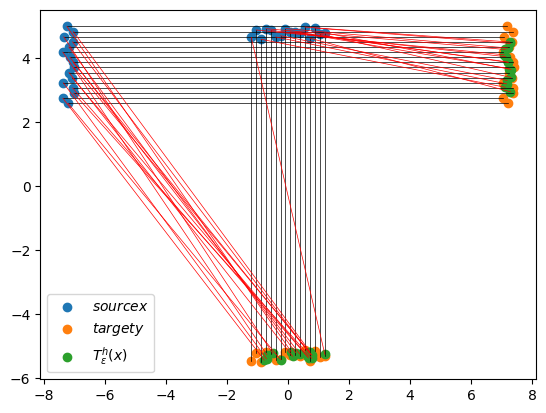

In [6]:
epsilon = 0.001

ot = get_L2_ot(T_train_x_samples, T_train_y_samples, epsilon)
entropic_f = partial(potential_fn, 
                    potential_g=ot.g, 
                    y = T_train_y_samples, 
                    weights_b = ot.ot_prob.b, 
                    epsilon = ot.geom.epsilon,
                    cost_fn=quad)

grad_f = get_grad_f(entropic_f)

T_L2_transported_x = T_x_samples - grad_f(T_x_samples)

plot_points(T_x_samples, T_y_samples, T_L2_transported_x, show=True)

## learn a convex cost $c(x,y) = h(x-y)$

100%|██████████| 500/500 [04:37<00:00,  1.80it/s, Loss: 0.037650315449415425, Alignment Loss: 0.0359412297238236, Fitting Loss: 0.0, Metric reg Loss: 0.0 Flow reg Loss: 0.0, max_cost_matrix: 1709.0857255918252]  


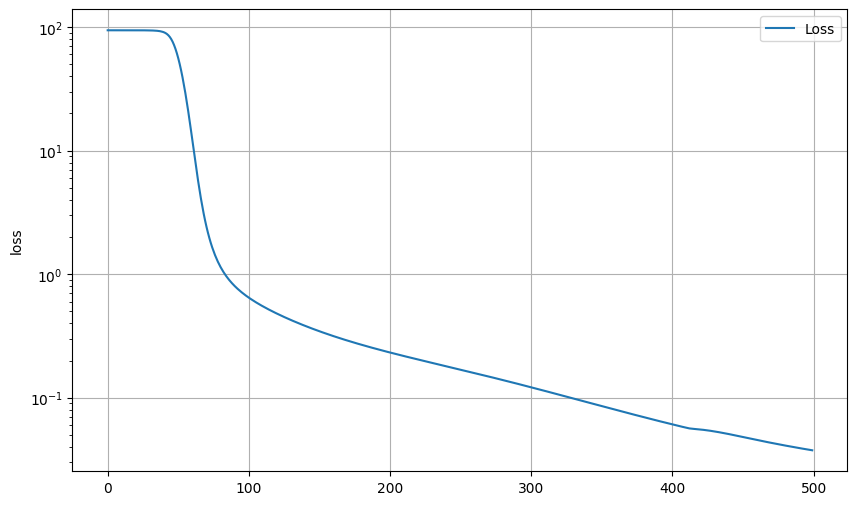

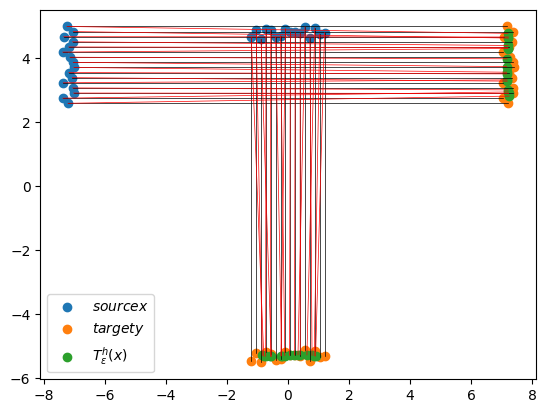

In [7]:
config = {
        'd': 2,
        'flow_type': 'none', # 'none' uses a convex cost h(x-y). Can be 'none', 'shared', 'separate'
        'symmetric_h': True,
        'num_steps': 500,
        'epsilon': 0.05,
        'end_epsilon': 0.002,
        'gamma': 1.0,
        'max_gamma': 1e-6,
        'flow_gamma': 1e-2,
        'lr': 1e-2,
        'flow_lr': 1e-4,
        'cost_hidden_dims': [32,32], 
        'inner_opt_tol': 1e-6, 
    }

init_key = jax.random.PRNGKey(0)
loss_obj = h_flow(init_key, config, **config)
params_lst, loss_lst = loss_obj.train(T_train_x_samples, T_train_y_samples)
plot_loss_curve(loss_lst, show=True)

learned_map = loss_obj.get_transport_map(T_train_x_samples, T_train_y_samples)

T_transported_x = learned_map(T_x_samples)

plot_points(T_x_samples, T_y_samples, T_transported_x, show=True)

## learning from limited pairs

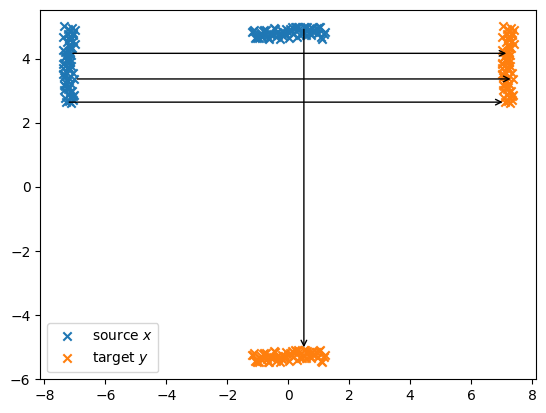

In [8]:
num_pairs = 4

key = jax.random.PRNGKey(0)
x_idxs = jax.random.choice(key, jnp.arange(T_train_x_samples.shape[0]), shape=(num_pairs,), replace=False)
y_idxs = x_idxs
alignment_idxs = (x_idxs, y_idxs)

plot_limited_pairs(T_train_x_samples, T_train_y_samples, x_idxs, y_idxs, show=True)

100%|██████████| 500/500 [03:50<00:00,  2.17it/s, Loss: 0.04979139701535462, Alignment Loss: 0.049737031897097855, Fitting Loss: 0.0, Metric reg Loss: 0.0 Flow reg Loss: 0.0, max_cost_matrix: 54.365118256763154] 


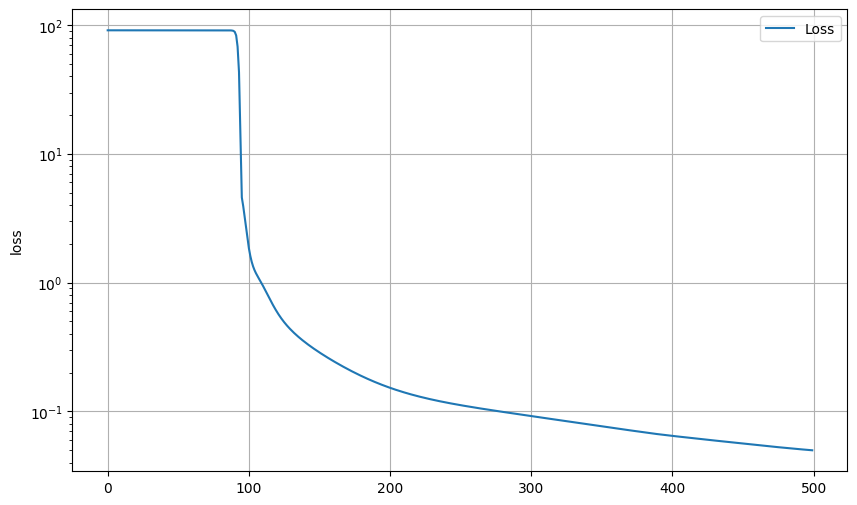

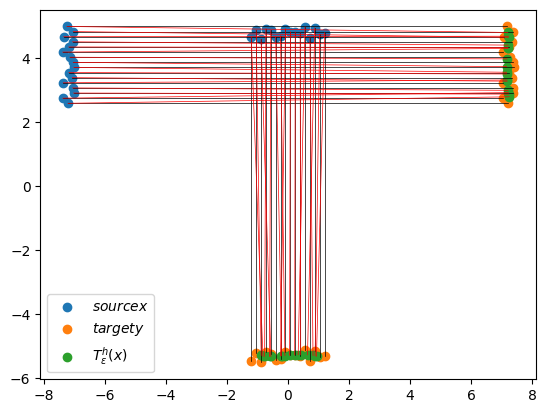

In [9]:
config = {
        'd': 2,
        'flow_type': 'none', # Can be 'none', 'shared', 'separate'
        'symmetric_h': True,
        'num_steps': 500,
        'epsilon': 0.05,
        'end_epsilon': 0.002,
        'gamma': 1.0,
        'max_gamma': 1e-6,
        'flow_gamma': 1e-2,
        'lr': 1e-2,
        'flow_lr': 1e-4,
        'cost_hidden_dims': [32,32], 
        'inner_opt_tol': 1e-6, 
    }


init_key = jax.random.PRNGKey(0)
loss_obj = h_flow(init_key, config, **config)
params_lst, loss_lst = loss_obj.train(T_train_x_samples, T_train_y_samples, alignment_idxs)
plot_loss_curve(loss_lst, show=True)

learned_map = loss_obj.get_transport_map(T_train_x_samples, T_train_y_samples)

T_transported_x = learned_map(T_x_samples)

plot_points(T_x_samples, T_y_samples, T_transported_x, show=True)